In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from pathlib import Path

import time
import math
from numba import jit
dir_vtk = Path("usableVTK")
dir_vtk.mkdir(parents=True, exist_ok=True)

## Assemble Coefficient Matrix


In [2]:
def calculate_coefficients(Lx,Ly,Nx,Ny,shear,mu,rhof,cell,rho,vis,D,implicit,v,i):
    
    def harmonic_mean(x,y):
        return 2*x*y/(x+y)
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    eqs = 3
    
    #smoothing coefficient used in implicit and explicit so do first
    if (D[cell]!=D[cell+1]): #if FSI floaterface no smoothing
        D_e = 0
    else:
        D_e = harmonic_mean(D[cell],D[cell+1])
        
    if (D[cell]!=D[cell-1]):
        D_w = 0
    else:
        D_w = harmonic_mean(D[cell],D[cell-1])
        
    if (D[cell]!=D[cell+Nx]):
        D_n = 0
    else:
        D_n = harmonic_mean(D[cell],D[cell+Nx])
    
    if (cell<Nx) or (D[cell]!=D[cell-Nx]): #do not compute for  bottom cell
        D_s = 0
    else:
        D_s = harmonic_mean(D[cell],D[cell-Nx])
    
    if implicit == True:
        #MOMENTUM
        #Laplacian velocity
        mu_e = harmonic_mean(vis[cell],vis[cell+1])
        
        a_e = mu_e*dy/dx

        mu_w = harmonic_mean(vis[cell],vis[cell-1])
        a_w = mu_w*dy/dx 

        mu_n = harmonic_mean(vis[cell],vis[cell+Nx])
        a_n = mu_n*dx/dy
        
        a_s = 0 
        if cell>=Nx: #don't compute for bottom cells
            mu_s = harmonic_mean(vis[cell],vis[cell-Nx])
            a_s = mu_s*dx/dy

        a_p = -(a_e+a_w+a_n+a_s)
        #Implicit pressure gradient
        Se = D_e*dy/dx
        
        Sw = D_w*dy/dx

        Sn = D_n*dx/dy
        
        Ss = D_s*dx/dy

        Sp = -(Se+Sw+Sn+Ss)
        gs=0
        #convection coefficients
        if rho[cell]==rhof:
            if (rho[cell]!=rho[cell+1]):
                ge = 0
            else:
                ge = -float(rhof*dy*(v[i+3]+v[i])/4) #Ae(vex+vpx)/4
            if (rho[cell]!=rho[cell-1]):
                gw = 0   
            else:
                gw = float(rhof*dy*(v[i-3]+v[i])/4) #-Aw(vwx+vpx)/4
            if (rho[cell]!=rho[cell+Nx]):
                gn = 0
            else:
                gn = -float(rhof*dx*(v[i+eqs*Nx+1]+v[i+1])/4) #An(vny+vpy)/4
            if (cell<Nx) or (rho[cell]!=rho[cell-Nx]):
                gs = 0
            else:
                gs = float(rhof*dx*(v[i-eqs*Nx+1]+v[i+1])/4) #-As(vsy+vpy)/4
        else:
            ge = 0
            gw = 0
            gn = 0
            gs = 0
            
        gp = ge+gn+gw+gs
        coefficients = np.array([a_e,a_w,a_n,a_s,a_p,Se,Sw,Sn,Ss,Sp,ge,gw,gn,gs,gp])
        return coefficients
    
    else:
        #explicit pressure gradient
        Re = D_e*dy/2
        
        Rw = D_w*dy/2
        
        Rn = D_n*dx/2
        
        Rs = D_s*dx/2
        
        coefficients = np.array([Re,Rw,Rn,Rs])
        
        return coefficients
    

In [3]:
def build_solid_block(Nx,Ny,height,pos):
    width = int(1/270*Nx)
    height = math.floor(0.5*Ny) #height of block
    start = math.floor(Nx*pos)
    solid_cells = np.array(())
    for i in range(0,height): #solid block of width "width"
         #where block starts down channel
        solid_col = np.arange(start,start+width, 1)#build each column of solid cells
        solid_cells = np.append(solid_cells,solid_col)
        start +=Nx
    return solid_cells.astype(int)

## Main Simulation

In [4]:
def assemble_matrix(Lx,Ly,Nx,Ny,mu,shear,dt, rhof, rhos,vin,scaleFactor, solid_cells,v):
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    # total number of cells
    
    M = int(Nx*Ny)
    
    #-----COEFFICIENTS----
    #X-MOM and Y_MOM
    #velocities
    axf = mu*dy/dx
    ayf = mu*dx/dy
    apf = -2*(axf+ayf)
    axs = dt*shear*dy/dx
    ays = dt*shear*dx/dy
    aps = -2*(axs+ays)
    
    Df = scaleFactor*dx*dy/apf
    Ds = scaleFactor*dx*dy/aps
    D_h = 2*Df*Ds/(Df+Ds)
    #LHS Pressure Gradient
    Sxf = (Df*dy)/dx
    Syf = (Df*dx)/dy
    Spf = -2*(Sxf+Syf)
    
    #pressures
    cx = dy/2
    cy = dx/2
    
    #Create material fields
    rho  = np.full(M,rhof)
    rho[solid_cells] = rhos #fluid or solid density
    
    vis = np.full(M,mu)
    vis[solid_cells] = shear*dt #shear or viscosity
    
    
    D = np.full(M,Df)
    D[solid_cells] = Ds #smoothing or viscosity
    
    eqs = 3 #3 equations (momentum x, y and continuity)
    
    #default alpha to be a fluid
    alpha = 1
    #Initialise coefficient matrix
    A = np.zeros((eqs*M, eqs*M))
     #Initialise source vector
    b = np.zeros((eqs*M, 1))
   
    internal = (Nx-2)*(Ny-2)
    top_wall = (Nx-2)
    fluid_cells_bot = Nx-2-4
    
    vertical_side = (Ny-2)
    numNonZeros = int(top_wall*20+fluid_cells_bot*20+vertical_side*20+vertical_side*19+4*16+66+internal*23)+400
    #20 top wall, 20 bot flui  cells, 20 inlet, 19 outlet, 16 solid cells bot, 66 corners, 23 internals
    data = np.zeros((numNonZeros))
    row_idx = np.zeros((numNonZeros ))
    col_idx = np.zeros((numNonZeros ))
    
    #coefficients[10]t indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    
    #Loop through each cell i
    
    coeffi=0
    for i,cell in zip(range(0, eqs*M, eqs),range(0,M,1)):
        alpha=1
        if cell in solid_cells:
            alpha = 0
        
        #CORNERS
        #bottom left
        if i == 0:
            ge = -rhof*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gn = -rhof*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4

            #X-MOM
            #-------#
            #RHS
            b[i] = -2*axf*vin[0]+dy*vin[0]**2*rhof
            #LHS
            
            #vpx
            data[coeffi] = apf-axf-ayf+ge+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = axf+ge
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            #vnx
            data[coeffi] = ayf+gn 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            #Pp
            data[coeffi] = cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = -2*axf*vin[1]+dy*vin[0]*vin[1]*rhof
            #LHS
            
            #vpy
            data[coeffi] = apf-axf-ayf+ge+gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = axf+ge
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vny
            data[coeffi] = ayf+gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#
            #LHS
            
            #vpx
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sxf
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Syf  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = Spf/2  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
           
        #bottom right
        elif i == botright:
            gw = rhof*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gn = -rhof*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = -axf-3*ayf+gw+gn-dy*v[i]*rhof
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = axf+gw 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            #vnx
            data[coeffi] = ayf+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = (4/3)*cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1

            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -axf-3*ayf+gw+gn-dy*v[i]*rhof  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = axf+gw
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            #vny
            data[coeffi] = ayf+gn 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#
 
            #LHS
            
            #vpx
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vny
            data[coeffi] = cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
#             #Pw
#             data[coeffi] = Sxf
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-1
            
#             coeffi+=1
            
#             #Pn
#             data[coeffi] = Syf  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+eqs*Nx+2
            
#             coeffi+=1
            
#             #Pp
#             data[coeffi] = -3*Sxf-Syf  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+2
            
#             coeffi+=1
            
        #Top Left
        elif i == topleft:
            
            ge = -rhof*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gs = rhof*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            
            #X-MOM
            #-------#
            #RHS
            b[i] = -2*axf*vin[0]+dy*rhof*vin[0]**2
            #LHS
            
            #vpx
            data[coeffi] = apf-axf-ayf+ge+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = axf+ge
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            #vsx
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pp
            data[coeffi] = cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #Y-MOM
            #-------#
            #RHS
            b[i+1] = -2*axf*vin[1]+dy*rhof*vin[0]*vin[1]
            #LHS
            
            #vpy
            data[coeffi] = apf-axf-ayf+ge+gs  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = axf+ge
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vsy
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
     
            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = -cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sxf
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Syf  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = Spf/2  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
     
        #top right
        elif i == topright:
            
            gw = rhof*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gs = rhof*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = -axf-3*ayf-rhof*dy*v[i]+gw+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = axf+gw
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            #vsx
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = (4/3)*cx
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
               
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -axf-3*ayf-rhof*dy*v[i]+gw+gs 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = axf+gw
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            #vsy
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = -cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vsx
            data[coeffi] = -cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
#             #Pw
#             data[coeffi] = Sxf
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-1
            
#             coeffi+=1
            
#             #Ps
#             data[coeffi] = Syf  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-eqs*Nx+2
            
#             coeffi+=1
            
#             #Pp
#             data[coeffi] = -3*Sxf-Syf  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+2
            
#             coeffi+=1
            
        #SIDES
        #bottom
        elif 0 < i < botright:
            
            #coefficients[ae,aw,an,as,ap,Se,Sw,Sn,Ss,Sp,ge,gw,gn,gs,gp]
            coefficients = calculate_coefficients(Lx,Ly,Nx,Ny,shear,mu,rhof,cell,rho,vis,D,True,v,i)
            
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            #FLUID AND SOLID HAVE SAME VELOCITY BCS
            if alpha==1: #fluid
                data[coeffi] = coefficients[4]-2*ayf+coefficients[-5]+coefficients[-4]+coefficients[-3] #ap-as... *2 because a_s set to zero in functuion
            else:
                data[coeffi] = coefficients[4]-2*ays
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = coefficients[1]+coefficients[-4] #aw+gw
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = coefficients[0]+coefficients[-5] #ae+ge
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = coefficients[2]+coefficients[-3] #an+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            if alpha==1:
                data[coeffi] = coefficients[4]-2*ayf+coefficients[-5]+coefficients[-4]+coefficients[-3] #ap-as... *2 because a_s set to zero in functuion
            else:
                data[coeffi] = coefficients[4]-2*ays
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = coefficients[1]+coefficients[-4] #aw  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = coefficients[0]+coefficients[-5] #ae  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vny
            data[coeffi] = coefficients[2]+coefficients[-3] #an  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1

            if alpha==1: #if fluid:
                data[coeffi] = -cy #Pn
                row_idx[coeffi] = i+1
                col_idx[coeffi] = i+eqs*Nx+2
                
                coeffi+=1
                
                data[coeffi] = cy #Pp
                row_idx[coeffi] = i+1
                col_idx[coeffi] = i+2
            
            else: #if solid
                data[coeffi] = -dx #Pn
                row_idx[coeffi] = i+1
                col_idx[coeffi] = i+eqs*Nx+2
                
                coeffi+=1
                
                data[coeffi] = dx #Pp
                row_idx[coeffi] = i+1
                col_idx[coeffi] = i+2
            
            coeffi+=1
            #CONTINUITY
            #-------#

            #LHS
            
            #vpy
            data[coeffi] = cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            if alpha == 1: #only add these if fluid cell as smoothing term blank for boundary solid
                #Pw
                data[coeffi] = coefficients[6]
                row_idx[coeffi] = i+2
                col_idx[coeffi] = i-1

                coeffi+=1

                #Pe
                data[coeffi] = coefficients[5]
                row_idx[coeffi] = i+2
                col_idx[coeffi] = i+5

                coeffi+=1

                #Pn
                data[coeffi] = coefficients[7]  
                row_idx[coeffi] = i+2
                col_idx[coeffi] = i+eqs*Nx+2

                coeffi+=1

                #Pp
                data[coeffi] = coefficients[9]#-Sp+Ss
                row_idx[coeffi] = i+2
                col_idx[coeffi] = i+2

                coeffi+=1
           
        #top
        elif topleft < i < topright:
            ge = -rhof*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gw = rhof*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gs = rhof*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = apf-ayf +ge+gw+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = axf+gw 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = axf+ge 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = apf-ayf+ge+gw+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = axf+gw
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = axf+ge 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vsy
            data[coeffi] = ayf+gs  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpy
            data[coeffi] = -cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -cy 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #Pw
            data[coeffi] = Sxf
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sxf
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Syf  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -2*Sxf-Syf  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
        #left / Inlet
        elif i in range(eqs*Nx,topleft,eqs*Nx):
            
            ge = -rhof*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gn = -rhof*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            gs = rhof*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            
            #X-MOM
            #-------#
            #RHS
            b[i] = -2*axf*vin[0]+rhof*dy*vin[0]**2
            #LHS
            
            #vpx
            data[coeffi] = -3*axf-2*ayf+ge+gn+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = axf+ge
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ayf+gn 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pp
            data[coeffi] = cx  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = -2*axf*vin[1]+rhof*dy*vin[0]*vin[1]
            #LHS
            #vpy
            data[coeffi] = -3*axf-2*ayf+ge+gn+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = axf+ge
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            
            #vny
            data[coeffi] = ayf+gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pn
            data[coeffi] = -cy  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = cx 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            
            #vny
            data[coeffi] = cy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -cy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sxf
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Syf
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Syf  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -Sxf-2*Syf  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
        #right / Outlet
        elif i in range(botright+eqs*Nx,topright,eqs*Nx):
            
            gw = rhof*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gn = -rhof*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            gs = rhof*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = -axf-2*ayf +gw+gn+gs-rhof*dy*v[i]   
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = axf+gw 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ayf+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = (4/3)*cx 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
    
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -axf-2*ayf+gw+gn+gs-rhof*dy*v[i]  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = axf+gw
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vny
            data[coeffi] = ayf+gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ayf+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1

            
            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = cx 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            
            #vny
            data[coeffi] = cy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -cy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
#             #Pw
#             data[coeffi] = Sxf
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-1
            
#             coeffi+=1
            
#             #Pn
#             data[coeffi] = Syf
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+eqs*Nx+2
            
#             coeffi+=1
            
#             #Ps
#             data[coeffi] = Syf  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-eqs*Nx+2
            
#             coeffi+=1
            
#             #Pp
#             data[coeffi] = Sp-Sxf  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+2
            
#             coeffi+=1
        else:
            #coefficients[ae,aw,an,as,ap,Se,Sw,Sn,Ss,Sp,ge,gw,gn,gs,gp]
            coefficients = calculate_coefficients(Lx,Ly,Nx,Ny,shear,mu,rhof,cell,rho,vis,D,True,v,i)
            
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = coefficients[4]+coefficients[-1]
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = coefficients[1]+coefficients[-4]
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = coefficients[0]+coefficients[-5]
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = coefficients[2]+coefficients[-3] 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = coefficients[3]+coefficients[-2]
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = cx 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -cx 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = coefficients[4]+coefficients[-1]
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = coefficients[1]+coefficients[-4]  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = coefficients[0]+coefficients[-5]
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            
            #vny
            data[coeffi] = coefficients[2]+coefficients[-3]
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = coefficients[3]+coefficients[-2]
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = cy
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#

            #LHS
            
            #vex
            data[coeffi] = cx 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = cy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -cy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -cx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #Pw
            data[coeffi] = coefficients[6]
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = coefficients[5]
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = coefficients[7]
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = coefficients[8]  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = coefficients[9]  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
#     print(coeffi,data[coeffi])
#     count = 0
#     B = np.zeros((eqs*M,eqs*M))
#     for i,j in zip(row_idx,col_idx):
#         B[int(i),int(j)] = data[count]
#         count+=1
    #compile coefficient matrix
    A = csr_matrix((data[0:coeffi+1], (row_idx[0:coeffi+1], col_idx[0:coeffi+1])), shape=(eqs*M,eqs*M))
    
    return A,b,rho,vis,D,Df
    





### Calculate Pressure Gradient of last iteration 


In [5]:

def calculate_gradients(Nx,Ny,Lx,Ly,v,solid_cells):
    
    dx = Lx/Nx
    dy = Ly/Ny
    eqs = 3 #3 equations (momentum x, y and continuity)
    # total number of cells
    M = int(Nx*Ny)
    
    gradP = np.zeros((2*M,1)) 
    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    #Loop through each cell i
    for i,coeff,cell in zip(range(0, eqs*M, eqs),range(0,2*M,2),range(0,M,1)):
        #CORNERS
        #bottom left
        if i == 0:
            
            gradP[coeff]  = (v[i+5]-v[i+2])/(2*dx) # (1/2)*(dp/dx)e == (PE-PP)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/(2*dy) #(1/2)*(dp/dy)n == (PN-PP)/2dy
               
        #bottom right
        elif i == botright:
                        
            gradP[coeff] = (2/(3*dx))*-v[i-1] # (PE-PW)/(3dx/2)
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/(2*dy) #(1/2)*(dp/dy)n == (PN-PP)/2dy
              
        elif i == topleft:
            gradP[coeff] = (v[i+5]-v[i+2])/(2*dx) #(1/2)*(dp/dx)e == (PE-PP)/2dy
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/(2*dy) #(1/2)*(dp/dy)s == (PP-PS)/2dy
            
            
        #top right
        elif i == topright:
            
            gradP[coeff] = (2/(3*dx))*-v[i-1] # (-PW)/(3dx/2)
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/(2*dy) #(1/2)*(dp/dy)s == (PP-PS)/2dy
            
            
        #SIDES
        #bottom
        elif 0 < i < botright:
            
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/(2*dy) #(1/2)*(dp/dy)n == (PN-PP)/2dy
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            
            
            
        #top
        elif topleft < i < topright:
                        
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/(2*dy) #(1/2)*(dp/dy)s == (PP-PS)/2dy
            
            
        #left / Inlet
        elif i in range(eqs*Nx,topleft,eqs*Nx):
           
            gradP[coeff] = (v[i+5]-v[i+2])/(2*dx) #(1/2)*(dp/dx)e == (PE-PP)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
            
        #right / Outlet
        elif i in range(botright+eqs*Nx,topright,eqs*Nx):
            
            gradP[coeff] = (2/(3*dx))*-v[i-1] # (-PW)/(3dx/2)
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
            
        else:
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
    

    return gradP

## Function That Exports Results to VTK


In [6]:
def map_cells_to_coordinates(Nx,Ny,Lx,Ly):
    dx  = Lx/Nx
    dy = Ly/Ny
    ycoord = np.arange(0,Ly+dy,dy, dtype=float)
    xcoord = np.arange(0,Lx+dx,dx, dtype=float)
    cells_to_coord = {}
    count = 0
    for y in ycoord:
        for x in xcoord:
            cells_to_coord[count] = '%f %f' %(x,y)
            count+=1
#                 f.write('%f %f 0.0 \n' %(x,y))
    return cells_to_coord

In [7]:
def orderOfMagnitude(number):
    return math.floor(math.log(number, 10))


## Rie-Chow Simulation


In [8]:

def FSI(Lx,Ly,Nx,Ny,mu,shear,dt,rhof,rhos, vin,scaleFactor,max_its,tol,vtk,solid_cells):
    dir_name = Path("Master Results")
    dir_name.mkdir(parents=True, exist_ok=True)
    

    # total number of cells
    M = int(Nx*Ny)
    #equations being solved
    eqs = 3
    
    #Initialise unknown vectors
    #Solution vector
    v = np.zeros((eqs*M, 1)) #results vector
    _,_,_,_,_,Df = assemble_matrix(Lx,Ly,Nx,Ny,mu,shear,dt, rhof, rhos,vin,scaleFactor,solid_cells,v)
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    ycoord = np.arange(dy/2,Ly,dy, dtype=float)
    xcoord = np.arange(dx/2,Lx,dx, dtype=float)
    #CONTINUITY
    #velocities
    ex = dy/2
    ey = dx/2
    
    #RHS Pressure Gradient
    Rx = (Df*dy)/2
    Ry = (Df*dx)/2
    
    
    vnew = np.zeros((eqs*M,1))
    
    #velocities and pressures
    vx = np.zeros((M, 1))#velocity x
    vxnew = np.zeros((M, 1)) #pressure
    vy = np.zeros((M, 1))#velocity y
    vynew = np.zeros((M, 1)) #pressure
    p = np.zeros((M, 1)) #pressure
    pnew = np.zeros((M, 1)) #pressure
    
    
    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    
    #list of residuals for each unknown
    residualsvx = []
    residualsvy = []
    residualsp = []
    init_resvx = 1
    init_resvy = 1
    init_resp = 1
    
    print('Iters, Residual vx, Residual vy, Residual p')
    
    for iterations in range(1,max_its+1):
        
        #calculate gradP for new iteration
        gradP = calculate_gradients(Nx,Ny,Lx,Ly,v,solid_cells)
        A,b,rho,vis,D,Df = assemble_matrix(Lx,Ly,Nx,Ny,mu,shear,dt, rhof, rhos,vin,scaleFactor,solid_cells,v)
        
        for i,coeff,cell in zip(range(0, eqs*M, eqs),range(0,2*M,2),range(0,M,1)):
            
            #CORNERS
            #bottom left
            if i == 0:
                #Rie-Chow
                #dy*vinx+re*dPe+rn*dPn+re*dPpx+rn*dPpy
                b[i+2] = 2*ex*vin[0]+gradP[coeff+2]*Rx+gradP[coeff+2*Nx+1]*Ry+gradP[coeff]*Rx+gradP[coeff+1]*Ry 
                                
            #bottom right
            elif i == botright:
                
                #-rw*dPw+rn*dPn+rn*dPpy
                b[i+2] = 0
#                 b[i+2] = -gradP[coeff-2]*Rx+gradP[coeff+2*Nx+1]*Ry+gradP[coeff+1]*Ry
            
            elif i == topleft:
                
                #re*dPe-rs*dPs+re*dPpx-rs*dPpy
                b[i+2] = 2*ex*vin[0]+gradP[coeff+2]*Rx-gradP[coeff-2*Nx+1]*Ry+gradP[coeff]*Rx-gradP[coeff+1]*Ry
                
            #top right
            elif i == topright:
               #-rw*dPw-rs*dPs-rs*dPpy
                b[i+2] = 0
#                 b[i+2] = -gradP[coeff-2]*Rx-gradP[coeff-2*Nx+1]*Ry-gradP[coeff+1]*Ry

            #SIDES
            #bottom
            elif 0 < i < botright:
                #coefficients[ae,aw,an,as,ap,Se,Sw,Sn,Ss,Sp,ge,gw,gn,gs,gp]
                coefficients = calculate_coefficients(Lx,Ly,Nx,Ny,shear,mu,rhof,cell,rho,vis,D,False,v,i)
                
                if cell in solid_cells:
                    b[i+2]=0 #no smoothing term in solid
                else:
                    #re*dPe-rw*dpW+rn*dPn+rn*dPpy
                    b[i+2] = gradP[coeff+2]*coefficients[0]-gradP[coeff-2]*coefficients[1]+\
                    gradP[coeff+1]*coefficients[2]+gradP[coeff+2*Nx+1]*coefficients[2]
            
            #top
            elif topleft < i < topright:
                 
                #re*dPe-rw*dPw-rs*dPs-rs*dPpy
                b[i+2] = gradP[coeff+2]*Rx-gradP[coeff-2]*Rx-gradP[coeff+1]*Ry-gradP[coeff-2*Nx+1]*Ry
            
            #left / Inlet
            elif i in range(eqs*Nx,topleft,eqs*Nx):
                
                #re*dPe+re*dPpx+rn*dPn-rs*dPs
                b[i+2] = 2*vin[0]*ex+gradP[coeff+2]*Rx+gradP[coeff]*Rx+gradP[coeff+2*Nx+1]*Ry -gradP[coeff-2*Nx+1]*Ry
            
            #right / Outlet
            elif i in range(botright+eqs*Nx,topright,eqs*Nx):
                
                #-rw*dPw+rn*dPn-rs*dPs
                b[i+2] = 0
#                 b[i+2] = -gradP[coeff-2]*Rx+gradP[coeff+2*Nx+1]*Ry-gradP[coeff-2*Nx+1]*Ry
            
            #internal
            else:
                ##coefficients[ae,aw,an,as,ap,Se,Sw,Sn,Ss,Sp,ge,gw,gn,gs,gp]
                coefficients = calculate_coefficients(Lx,Ly,Nx,Ny,shear,mu,rhof,cell,rho,vis,D,False,v,i)
                #re*dPe-rw*dPw+rn*dPn-rs*dPs
            
                b[i+2] = gradP[coeff+2]*coefficients[0]-gradP[coeff-2]*coefficients[1]\
                +gradP[coeff+2*Nx+1]*coefficients[2]-gradP[coeff-2*Nx+1]*coefficients[3]
        
        #solve system
        t = time.time()
        vnew = scipy.sparse.linalg.spsolve(A,b)

#         print("Time to solve system",time.time() - t)
        
        #get components of solution vector
        vxnew = vnew[0::3].reshape(M,1) #vx component
        vynew = vnew[1::3].reshape(M,1) #vy component
        pnew = vnew[2::3].reshape(M,1) #pressure component
        
        #calculate residuals
        resvx = np.linalg.norm(vxnew-vx)/init_resvx
        resvy = np.linalg.norm(vynew-vy)/init_resvy
        resp = np.linalg.norm(pnew-p)/(init_resp)
        
        #store residuals
        residualsvx.append(resvx)
        residualsvy.append(resvy)
        residualsp.append(resp)
        
        if (iterations==1):
            # Use a small number if the initial residual is small
            init_resvx = max(resvx, 1e-12)
            init_resvy = max(resvy, 1e-12)
            init_resp = max(resp, 1e-12)
            resvx = 1
            resvy = 1
            resp = 1
            
       
        #update solution
        vx = vxnew
        vy = vynew
        p = pnew
        v = vnew
        
        #print residuals
        print(iterations,resvx, resvy, resp)
        print('\n')
        
        #break loop if tolerance reached
        if (resvx < tol and resvy<tol and resp<tol):
            print("tolerance reached in %i iterations"%(iterations+1))
            break
            
    #get velocity magnitude
    vmag = np.sqrt(np.square(vx)+np.square(vy))
    dispx = dt*vx
    disp = vmag*dt
    #get pressure gradient from numerical answer
    pressure_gradient = np.mean(np.diff(p[int(0.5*Nx):]/dx,axis=0))
#     print(np.diff(vmag,axis=0))
    
    
    #PLOTTING
    X,Y = np.meshgrid(np.arange(0,Lx,dx),np.arange(0,Ly,dy))
    
    vmagplot = np.reshape(vx, (Ny, Nx))#velocity plot
    pressure_plot = np.reshape(p,(Ny, Nx))#pressure plot
    
   #VELOCITY
    plt.figure(figsize=(18,3))
    
#     mag_v = -orderOfMagnitude(np.max(vmag))

    plt.contourf(X,Y,vmagplot,cmap='inferno')
    plt.colorbar(label="Velocity (1e-i m/s)")
    plt.title("Velocity Magnitude Distribution", fontsize=15)
    
    plt.savefig(dir_name/"VmagPvcoupling")
#     p[solid_cells] = 0
    #PRESSURE
    plt.figure(figsize=(18,3))
#     mag_p = -orderOfMagnitude(np.mean(p))
#     mag_p = 4
    plt.contourf(X,Y,pressure_plot,cmap='inferno')
    plt.colorbar(label="Pressure (1e-i Pa)")
    plt.title("Pressure Distribution Shear Modulus = 1e%i"%(orderOfMagnitude(shear)),fontsize=15)
#     plt.savefig(dir_name/"PressureShear1e%i.png"%(orderOfMagnitude(shear)))
    
    #PRESSURE
    plt.figure(figsize=(18,3))
#     mag_p = -orderOfMagnitude(np.mean(p))
#     mag_p = 4
    plt.quiver(X,Y,vmagplot,cmap='inferno')
    plt.colorbar(label="Velocity (1e-i m/s)")
    plt.title("Velocity Vector Distribution", fontsize=15)
#     plt.savefig(dir_name/"PressureShear1e%i.png"%(orderOfMagnitude(shear)))

    #Print the Reynolds Number
    Re = vin[0] * Ly *rhof/mu
    print("Reynolds Number =", Re)
    print("Maximum Velocity", np.max(vmag))
    print("Maximum Pressure", np.max(p))
    print("avg solid disp",np.mean(disp[solid_cells]))
    print("max solid disp x",np.max(dispx[solid_cells]))
    #Run the Analytical solution for these parameters
    
    #convert lists to arrays
    residualsvx = np.array(residualsvx)
    residualsvy = np.array(residualsvy)
    residualsp = np.array(residualsp)
    residuals = np.zeros((iterations,3))
    residuals[:,0] = residualsvx
    residuals[:,1] = residualsvy
    residuals[:,2] = residualsp

#     print(p[Nx])
    #export to VTK format
    if vtk:
        solid_vtk_results(v,dt*vmag[solid_cells],p[solid_cells],Nx,Ny,Lx,Ly,solid_cells,Re)
        fluid_vtk_results(v,vmag,p,Nx,Ny,Lx,Ly,solid_cells,Re)        
    return v,iterations,residuals



## Run Code

In [11]:
4/math.sqrt(2)

2.82842712474619

Iters, Residual vx, Residual vy, Residual p
1 1 1 1


2 0.28816546209923916 0.9357514213750938 0.9539713955953835


3 0.23559756962188538 0.5938349435407176 0.4693124097409302


4 0.12766688630371123 0.34517829185190363 0.32450168821829734


5 0.06603763071739527 0.21813399126530897 0.10776336461960677


6 0.051908834384866244 0.1872949157498692 0.06583163212331923


7 0.036067251323639714 0.13516206246951723 0.03918238142868428


8 0.022869483303650837 0.09139696392958668 0.01866846623172757


9 0.012114928949077574 0.05444397641202493 0.012787211557505404


10 0.006577282088059799 0.03078611055602689 0.0071975122929005325


11 0.003620948393850026 0.01714411452019739 0.003933424622642796


12 0.0019341289456148414 0.009593966070345112 0.002197014407085699


13 0.0012091104071723288 0.005912941438361803 0.0013004766401812566


14 0.0008215058734487321 0.003932621780180124 0.0008086264603135846


15 0.0005672743661945829 0.0026134355410892527 0.0005146665035810766


16 0.00040850570803

NameError: name 'solid_vtk_results' is not defined

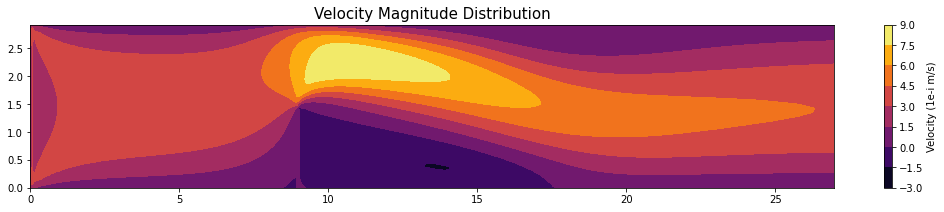

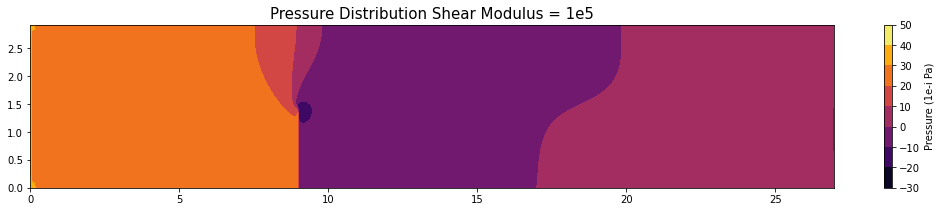

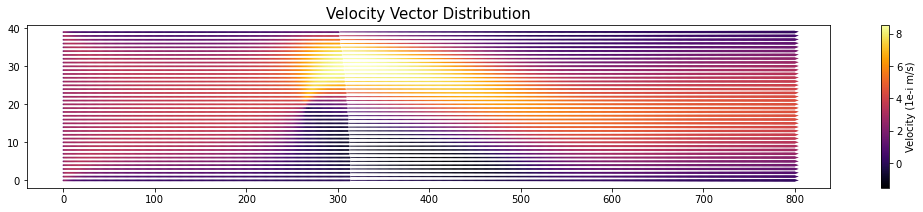

In [10]:
#DIMENSIONS
Lx = 27
Ly = 3
Nx =800
dx = Lx/Nx
Ny = 40
M = int(Nx*Ny)


dy = Ly/Ny

#solid block
pos = 1/3
height = 1/3
solid_cells = build_solid_block(Nx,Ny,height,pos)
ycoord = np.arange(dy/2,Ly,dy, dtype=float) #cell centre coordinates
xcoord = np.arange(dx/2,Lx,dx, dtype=float)

#MATERIAL PROPERTIES
rhof = 1 #fluid density
rhos = 1 #solid density

mu = 8.6e-2 #fluid dynamic viscosity
shear = 2.5e6/3 #solid shear modulus

#OTHER PARAMETERS
max_its = 20#max iterations
tol = 1e-15 #residual tolerance
dt = 1 #time step
vin = np.array([4/math.sqrt(2),0]) #input velocity
scaleFactor = 1 #smoothing coefficient scaling
vtk = True #export results to VTK foramat

#Map cells to coordinates
cells_to_coord = map_cells_to_coordinates(Nx,Ny,Lx,Ly)
coord_to_cells = {v: k for k, v in cells_to_coord.items()}

v,iterations,residuals = FSI(Lx,Ly,Nx,Ny,mu,shear,dt,rhof,rhos, vin,scaleFactor,max_its,tol,vtk,solid_cells)

vmag = np.sqrt(np.square(v[0::3].reshape(M,1))+np.square(v[1::3].reshape(M,1)))
p = v[2::3].reshape(M,1)
max_disp = np.max(vmag*dt)
max_v = np.max(vmag)
max_p = np.max(p)
Re = vin[0] * Ly *rhof/mu

# Gather Results

In [18]:
dir_name = Path("flexible results")
dir_name.mkdir(parents=True, exist_ok=True)

## Solid Results

In [15]:
def solid_vtk_results(v,disp,p,Nx,Ny,Lx,Ly,solid_cells,Re):
    
    dx = Lx/Nx
    dy = Ly/Ny
    points_x = math.floor(1/50*Nx)+1
    
    points_y = math.floor(Ny/2)+1

    begin_x = float(cells_to_coord[solid_cells[0]].split()[0])
    begin_y = float(cells_to_coord[solid_cells[0]].split()[1])
    xcoord = np.arange(begin_x,begin_x+(points_x-1)*dx,dx)
    ycoord = np.arange(begin_y,begin_y+(points_y)*dy,dy)

    order_d = orderOfMagnitude(np.max(disp))
    order_p = orderOfMagnitude(p[0])
    disp = disp*10**-order_d
    v = v*10**-order_d
    p = p*10**-order_p
    fname = 'solidRe=%fshear=1e%i.vtk'%(Re,orderOfMagnitude(shear))
    Nz = 1
    preamble = '# vtk DataFile Version 2.0\nTube Example\nASCII \n' 
    with open(dir_name/fname, "w") as f:
        f.write(preamble)
        f.write('DATASET STRUCTURED_GRID DIMENSIONS %i %i %i\n'%(points_x,points_y,Nz))
        f.write('POINTS %i float\n' %((points_x)*(points_y)))
        
        #inputs coordinates
        for y in ycoord:
            for x in xcoord:
                f.write('%f %f 0.0 \n' %(x,y))
                
        #input velocities
        f.write('CELL_DATA %i\n'%(len(solid_cells)))
        f.write('SCALARS DisplacementMagnitude(1e%im/s) float 1\nLOOKUP_TABLE default\n'%-order_d)
        for d in disp:
            f.write('%.8f\n'%(d))
        
        #input pressure
        f.write('SCALARS LeafletPressure(1e%iPa) float 1\nLOOKUP_TABLE default\n'%-order_p)
        for pe in p:
            f.write('%.8f\n'%(pe))
        
#         #input velocity vectors
#         f.write('VECTORS Velocity(1e%im/s) float\n'%-order_d)
#         for i in range(0,len(v)-1,3):
#             f.write('%f %f 0\n'%(v[i],v[i+1]))


In [16]:
def fluid_vtk_results(v,vmag,p,Nx,Ny,Lx,Ly,solid_cells,Re):
    
    dx = Lx/Nx
    dy = Ly/Ny
    ycoord = np.arange(0,Ly+dy,dy, dtype=float)
    xcoord = np.arange(0,Lx+dx,dx, dtype=float)
    order_v = orderOfMagnitude(np.max(vmag))
    order_p = orderOfMagnitude(p[0])
    vmag_copy = vmag
    vmag_copy[solid_cells] = 0
    p_copy = p
    p_copy[solid_cells] = 0
    vmag_copy = vmag*10**-order_v
    v = v*10**-order_v
    p_copy = p_copy*10**-order_p
    fname = 'fluidRe=%.3ffshear=1e%i.vtk'%(Re,orderOfMagnitude(shear))
    Nz = 1
    preamble = '# vtk DataFile Version 2.0\nTube Example\nASCII \n' 
    with open(dir_name/fname, "w") as f:
        f.write(preamble)
        f.write('DATASET STRUCTURED_GRID DIMENSIONS %i %i %i\n'%(Nx+1,Ny+1,Nz))
        f.write('POINTS %i float\n' %((Nx+1)*(Ny+1)))
        count = 0
        
        #inputs coordinates
        for y in ycoord:
            for x in xcoord:
                f.write('%f %f 0.0 \n' %(x,y))
                
        #input velocities
        f.write('CELL_DATA %i\n'%((Nx)*(Ny)))
        f.write('SCALARS VelocityMagnitude(1e%im/s) float 1\nLOOKUP_TABLE default\n'%-order_v)
        for vel in vmag_copy:
            f.write('%.8f\n'%(vel))
        
        #input pressure
        f.write('SCALARS FluidPressure(1e%iPa) float 1\nLOOKUP_TABLE default\n'%-order_p)
        for pe in p_copy:
            f.write('%.8f\n'%(pe))
        
        #input velocity vectors
        f.write('VECTORS Velocity(1e%im/s) float\n'%-order_v)
        for i in range(0,len(v)-1,3):
            f.write('%f %f 0\n'%(v[i],v[i+1]))

            

In [22]:
# solid_vtk_results(v,dt*vmag[solid_cells],p[solid_cells],Nx,Ny,Lx,Ly,solid_cells,Re,shear)
fluid_vtk_results(v,vmag,p,Nx,Ny,Lx,Ly,solid_cells,Re,shear)

NameError: name 'v' is not defined

## Velocity

Get velocity in y direction on the middle line of the third solid cell

In [197]:
def free_stream_section(vmag, per_cent, Nx, Ny): #per_cent is where to cut the cross section
    
    bot = math.ceil(Nx*per_cent) #middle cell bottom of block
    top = bot+int(Nx*Ny)#middle cell top of block
    cells = np.arange(bot,top,Nx)#cells along middle of block
    vel_free = vmag[cells]
    vel_free = np.insert(vel_free, 0, 0, axis=None)
    vel_free = np.insert(vel_free, len(vel_free), 0, axis=None)
    plt.plot(vel_free)
    return vel_free

In [169]:
vmidPython = vel_area_section(vmag, Nx,Ny)

## Pressure 

Pressure in x direction at three quarter height of channel

In [171]:
def PmidChannel(p,Nx,Ny):
    
    
    left = math.floor((3*Ny/4))*Nx
    cells = np.arange(left,left+Nx)
    pmiddle = p[cells]
    return pmiddle
    

In [172]:
pmidPython = PmidChannel(p,Nx,Ny)

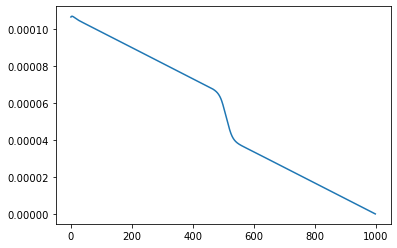

In [173]:
plt.plot(pmidPython)

## Deformation

In [174]:
def def_area_section(disp, Nx,Ny): #per_cent is where to cut the cross section
    bot = coord_to_cells["0.120000 0.000000"]
    top = coord_to_cells["0.120000 0.004800"]
    top = math.floor(Nx/2+Ny/2*Nx)-1 #top solid cell 
    bot = math.floor(Nx/2)
    half_way = int((1/50*Nx)/2)
    cells = np.arange(bot+half_way,top+half_way,Nx)#cells along middle of block
    disp_y = vmag[cells]
    return disp_y

In [185]:
disp_y = def_area_section(vmag*dt, Nx,Ny)

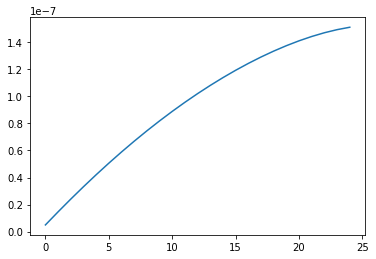

In [176]:
plt.plot(disp_y)

## Ansys Results

### Velocity above leaflet

Read in ansys velocity file (be sure to specify y coordinates correctly): [(Nx*dx+dx/2, 1/2 height+dy/2), (Nx*dx+dx/2, height-dy/2)]

In [186]:
file_name = "/Users/eoinmolloy/Downloads/vmid.csv"
ansys_vel = np.loadtxt(file_name,delimiter=",", dtype=float)


### Pressure across channel midway between leaflet and top wall

Read in ansys pressure file (be sure to specify y coordinates correctly): [0, 1/2 height+dy/2), (Nx*dx-dx/2, height-dy/2)]

In [187]:
file_name = "/Users/eoinmolloy/Downloads/pmid.csv"
ansys_p = np.loadtxt(file_name,delimiter=",", dtype=float)


### Deformation down solid block halfway across solid block

In [213]:
file_name = "/Users/eoinmolloy/Downloads/def.txt"
ansys_disp = np.loadtxt(file_name,delimiter="\t", dtype=float)
coord = ansys_disp[0::2,0]
ansys_disp = np.flip(ansys_disp[0::2],axis=1)
ansys_disp[:,1]=np.flip(coord)

# Plotting

## Velocity

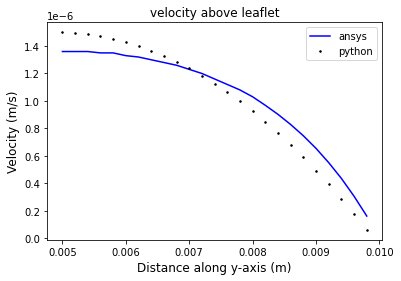

In [189]:
plt.figure()
plt.plot(ansys_vel[:,0], ansys_vel[:,1], 'b',ansys_vel[:,0], vmidPython,'ko', markersize = 1.5)
plt.title('velocity above leaflet', fontsize = 12, weight = 500)
plt.xlabel('Distance along y-axis (m)', fontsize = 12, weight = 500)
plt.ylabel('Velocity (m/s)', fontsize = 12, weight = 500)
plt.legend(['ansys', 'python'])
plt.savefig(dir_name/'velocity.png')

## Pressure

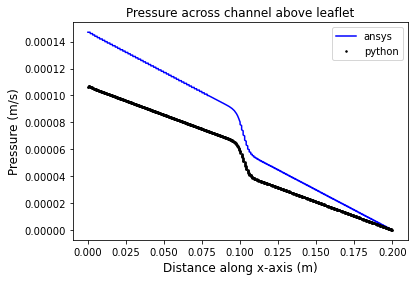

In [191]:
plt.figure()
plt.plot(ansys_p[:,0],ansys_p[:,1], 'b',ansys_p[:,0], pmidPython,'ko', markersize = 1.5)
plt.title('Pressure across channel above leaflet', fontsize = 12, weight = 500)
plt.xlabel('Distance along x-axis (m)', fontsize = 12, weight = 500)
plt.ylabel('Pressure (m/s)', fontsize = 12, weight = 500)
plt.legend(['ansys', 'python'])
plt.savefig(dir_name/'pressure.png')

## Deformation

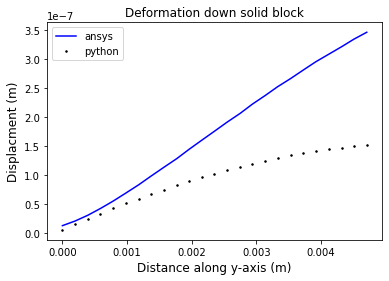

In [217]:
plt.figure()
plt.plot(ansys_disp[:,1], ansys_disp[:,0], 'b',np.flip(ansys_disp[:,1]), disp_y,'ko', markersize = 1.5)
plt.title('Deformation down solid block', fontsize = 12, weight = 500)
plt.xlabel('Distance along y-axis (m)', fontsize = 12, weight = 500)
plt.ylabel('Displacment (m)', fontsize = 12, weight = 500)
plt.legend(['ansys', 'python'])
plt.savefig(dir_name/'deformation.png')

## Residual Error

In [30]:

def plot_residuals(residuals,iterations):
    
    residualsvx=residuals[:,0]
    residualsvy=residuals[:,1]
    residualsp=residuals[:,2]
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    iters_array = np.arange(1,iterations+1)

    ax1.plot(iters_array,residualsvx, 'b',iters_array,residualsvy, 'k',iters_array,residualsp,'r', marker = 'o',markersize = 1)
    fig.legend(['u', 'v','p'],bbox_to_anchor=(0.75, 0.55))
    fig.suptitle('Residual error of u,v,p versus iterations (dt =%.2f )'%dt, fontsize = 12, weight = 500)
    ax1.set_xlabel('Number of Iterations', fontsize = 12, weight = 500)
    plt.yscale('log')
    ax1.set_ylabel('Normalised Residual Error', fontsize = 12, weight = 500)
    plt.savefig('residualsdt=%.2f.png'%dt)

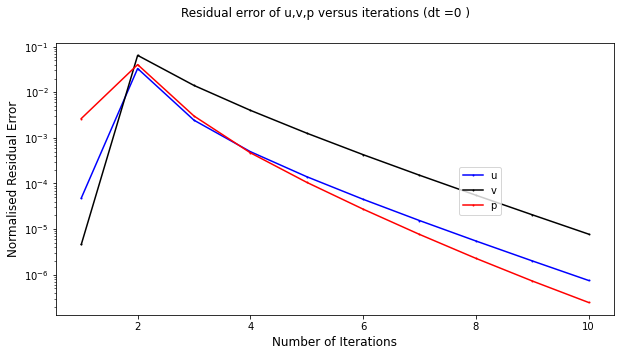

In [29]:
plot_residuals(residuals,iterations)

## Get Freestream Profile from previous simulation

## Analytical vs Numerical Free Stream Velocity Plot

Assuming simulation ran before

In [16]:
plt.figure()
vel_free  = free_stream_section(vmag, 0.7, Nx) #free stream values at 70% of cross section

plt.plot(ycoord, u/np.max(u), 'b',ycoord, vel_free/np.max(vel_free),'ko', markersize = 1.5)
plt.title('Free stream velocity numerical vs analytical solution', fontsize = 12, weight = 500)
plt.xlabel('Distance along y-axis (m)', fontsize = 12, weight = 500)
plt.ylabel('Normalised velocity (u/U)', fontsize = 12, weight = 500)
plt.legend(['analytical', 'numerical'])
plt.savefig('pvcopulingnumvsanalytical.png')

NameError: name 'u' is not defined

<Figure size 432x288 with 0 Axes>

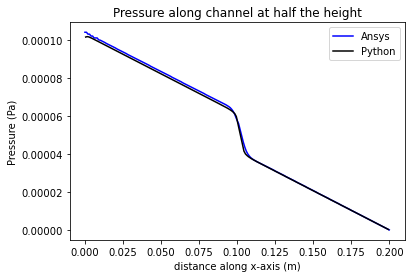

In [135]:
plt.plot(pmidAnsys[:, 0],pmidAnsys[:,1], 'b', xcoord, pmiddle, 'k')
plt.legend(['Ansys', 'Python'])
plt.xlabel("distance along x-axis (m)")
plt.ylabel("Pressure (Pa)")
plt.title("Pressure along channel at half the height")
plt.savefig("pmiddle_Ansys_vs_python.png")

In [142]:
ycoord[int(Ny/2):]

array([0.0055, 0.0065, 0.0075, 0.0085, 0.0095])

In [163]:
vmidPython

array([[1.31473071e-06],
       [2.36603141e-06],
       [2.58092688e-06],
       [2.10984955e-06],
       [9.57462280e-07]])

In [140]:
vmidAnsys[1:,0]

array([0.00556, 0.00611, 0.00667, 0.00722, 0.00778, 0.00833, 0.00889,
       0.00944, 0.01   ])

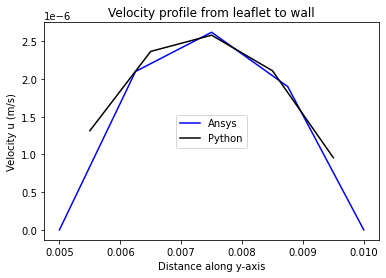

In [164]:
plt.plot(vmidAnsys[0:, 0],vmidAnsys[0:,1],'b',ycoord[int(Ny/2):],vmidPython,'k')
plt.legend(['Ansys', 'Python'],loc='center')
plt.xlabel("Distance along y-axis")
plt.ylabel("Velocity u (m/s)")
plt.title("Velocity profile from leaflet to wall")
plt.savefig("vmid_Ansys_vs_Python.png")

In [158]:
pmidAnsys = np.loadtxt("AnsysData/pmidvalues.csv",
                 delimiter=",", dtype=float)
vmidAnsys = np.loadtxt("/Users/eoinmolloy/Downloads/velocitymid (2).csv",
                 delimiter=",", dtype=float)

NameError: name 'dir_name' is not defined

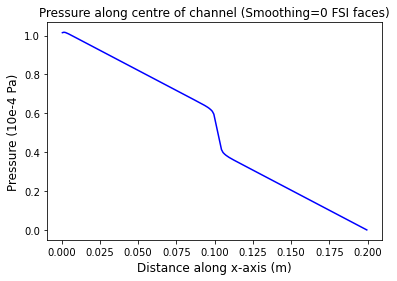

In [133]:
pmiddle = PmidChannel(p,Nx,Ny,xcoord)
mag = -orderOfMagnitude(pmiddle[0])
plt.figure()
plt.plot(xcoord, pmiddle*10**mag, 'b', markersize = 1.5)
plt.title('Pressure along centre of channel (Smoothing=0 FSI faces)', fontsize = 12, weight = 500)
plt.xlabel('Distance along x-axis (m)', fontsize = 12, weight = 500)
plt.ylabel('Pressure (10e-%i Pa)'%mag, fontsize = 12, weight = 500)
plt.savefig(dir_name/'pmidChannel_noSmoothing.png')

## Discretisation Error

In [27]:
def diff_numerical_analytical(meshesx,meshesy):
    mses = []
    for num_cellsx,num_cellsy in zip(meshesx,meshesy):
#         print(num_cells)
#         print(Lx,Ly,num_cells,num_cells,mu,rho, vin,ScaleFactor,max_its,tol,vtk)
#         print(meshesx,meshesy)
        vmag,p,v,iterations,residualsp,residualsvx, residualsvy,pressure_gradient = FSI(Lx,Ly,Nx,Ny,mu,shear,dt,rhof,rhos, vin,scaleFactor,max_its,tol,vtk,solid_cells)
        
        vx = v[0::3].reshape(num_cellsx**2,1) #vy component
        v_num = free_stream_section(vx, 0.7, num_cellsx) #
        mse = ((v_an.reshape(num_cellsx,1) - v_num)**2).mean(axis=0)
        mses.append(mse)
        print(mse)
                    
    return np.array(mses)

## Run Code - WARNING LONG RUN TIME

Time to assemble matrix 0.4619719982147217
Iterations, Residual vx, Residual vy, Residual p
1 1 1 1


2 0.0008882534610376669 0.004435044857664949 0.0012425301353688263


3 4.4410671827468796e-05 0.0005108913256542539 6.409382582033005e-05


4 1.0974310238650547e-05 0.00012334991534459046 1.6427702183943454e-05


5 3.176929827339347e-06 3.5658288183141206e-05 4.829795248334239e-06


6 9.878716056945892e-07 1.109017302898191e-05 1.507737613112465e-06


7 3.1922520884096254e-07 3.5845523077089097e-06 4.86670460329803e-07


8 1.0557065155334577e-07 1.1856044306773986e-06 1.604125198476302e-07


9 3.5442866566247824e-08 3.980623414014841e-07 5.362789147834879e-08


tolerance reached in 10 iterations
Reynolds Number = 0.010500000000000002


ValueError: cannot reshape array of size 10000 into shape (2500,1)

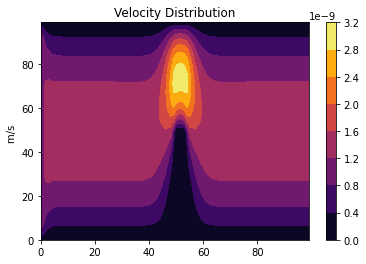

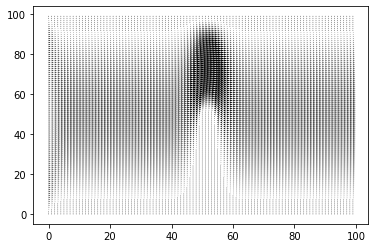

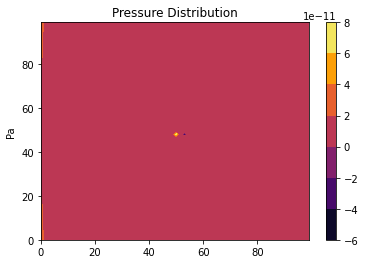

In [28]:

meshesx = np.array([50,100,200,400])
meshesy = meshesx
mses = diff_numerical_analytical(meshesx,meshesy)

mses for previous run

In [287]:
mses = (np.array([1.01082236e-16,2.08708333e-17,3.09206572e-18,1.13518052e-19]))

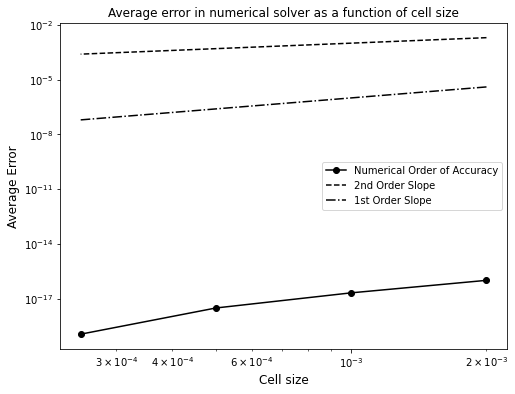

In [290]:

fig = plt.figure(figsize=(8,6))
scale = 1
plt.plot(Lx/meshesx,mses, color = 'k', marker = 'o')
plt.plot(Lx/meshesx/scale,Lx/meshesx, 'k--')
plt.plot(Lx/meshesx/scale,(Lx/meshesx)**2, 'k-.')
plt.xscale('log')
plt.yscale('log')
plt.title('Average error in numerical solver as a function of cell size', fontsize = 12, weight = 500)
plt.xlabel('Cell size', fontsize = 12, weight = 500)
plt.ylabel('Average Error', fontsize = 12, weight = 500)
plt.legend(['Numerical Order of Accuracy', '2nd Order Slope','1st Order Slope'],loc='center right')
plt.savefig('2nd order convergence.png')

In [159]:
def build_fluid_blocks(Nx,Ny,height,pos):
    
    #BLOCK 1
    start = 0
    width = Nx/2
    height = Ny
    fluid_cells1 = np.array(())

    for i in range(0,height): #solid block of width "width"
         #where block starts down channel
        fluid_col = np.arange(start,start+width, 1)#build each column of solid cells
        fluid_cells1 = np.append(fluid_cells1,fluid_col)
        start +=Nx
        
    #BLOCK 2
    width = int(1/50*Nx)
    height = math.floor(0.5*Ny)
    start = math.floor(Nx*pos+height*Nx)
    fluid_cells2 = np.array(())
    
    for i in range(0,height): #solid block of width "width"
         #where block starts down channel
        fluid_col = np.arange(start,start+width, 1)#build each column of solid cells
        fluid_cells2 = np.append(fluid_cells2,fluid_col)
        start +=Nx
    
    #BLOCK 3
    width = Nx/2-width
    height = Ny
    start = math.floor(Nx*pos+int(1/50*Nx))
    fluid_cells3 = np.array(())
    for i in range(0,height): #solid block of width "width"
         #where block starts down channel
        fluid_col = np.arange(start,start+width, 1)#build each column of solid cells
        fluid_cells3 = np.append(fluid_cells3,fluid_col)
        start +=Nx
        
    return fluid_cells1.astype(int),fluid_cells2.astype(int),fluid_cells3.astype(int)

In [180]:
def fluid_vtk_results(v,disp,p,Nx,Ny,Lx,Ly,solid_cells):
    
    dx = Lx/Nx
    dy = Ly/Ny
    
    block1,block2,block3 = build_fluid_block(Nx,Ny,0.5,0.5)
    
    points_x1 = Nx/2+1
    points_y1 = Ny+1
    
    points_x2 = math.floor(1/50*Nx)+1
    points_y2 = math.floor(Ny/2)+1
    
    points_x3 = Nx/2+1-points_x2
    points_y3 = Ny+1
    
    
    begin_x1 = float(cells_to_coord[block1[0]].split()[0])
    begin_y1 = float(cells_to_coord[block1[0]].split()[1])
    
    begin_x2 = float(cells_to_coord[block2[0]].split()[0])
    begin_y2 = float(cells_to_coord[block2[0]].split()[1])
    
    begin_x3 = float(cells_to_coord[block3[0]].split()[0])
    begin_y3 = float(cells_to_coord[block3[0]].split()[1])
    
    
    xcoord1 = np.arange(begin_x1,begin_x1+(points_x1-1)*dx,dx)
    ycoord1 = np.arange(begin_y1,begin_y1+(points_y1)*dy,dy)
    
    xcoord2 = np.arange(begin_x2,begin_x2+(points_x2-1)*dx,dx)
    ycoord2 = np.arange(begin_y2,begin_y2+(points_y2)*dy,dy)
    
    xcoord3 = np.arange(begin_x3,begin_x3+(points_x3-1)*dx,dx)
    ycoord3 = np.arange(begin_y3,begin_y3+(points_y3)*dy,dy)
    
    order_d = orderOfMagnitude(np.max(disp))
    order_p = orderOfMagnitude(p[0])
    disp = disp*10**-order_d
    v = v*10**-order_d
    p = p*10**-order_p
    fname1 = 'fluid1_vtk.vtk'
    fname2 = 'fluid2_vtk.vtk'
    fname3 = 'fluid3_vtk.vtk' 
    Nz = 1
    preamble = '# vtk DataFile Version 2.0\nTube Example\nASCII \n' 
    with open(dir_vtk/fname1, "w") as f:
        f.write(preamble)
        f.write('DATASET STRUCTURED_GRID DIMENSIONS %i %i %i\n'%(points_x1,points_y1,Nz))
        f.write('POINTS %i float\n' %((points_x1)*(points_y1)))
        
        #inputs coordinates
        for y in ycoord1:
            for x in xcoord1:
                f.write('%f %f 0.0 \n' %(x,y))
        
#         #input velocities
#         f.write('CELL_DATA %i\n'%(len(solid_cells)))
#         f.write('SCALARS DisplacementMagnitude(1e%im/s) float 1\nLOOKUP_TABLE default\n'%-order_d)
#         for d in disp:
#             f.write('%.8f\n'%(d))
        
#         #input pressure
#         f.write('SCALARS Pressure(1e%iPa) float 1\nLOOKUP_TABLE default\n'%-order_p)
#         for pe in p:
#             f.write('%.8f\n'%(pe))
        
#         #input velocity vectors
#         f.write('VECTORS Velocity(1e%im/s) float\n'%-order_d)
#         for i in range(0,len(v)-1,3):
#             f.write('%f %f 0\n'%(v[i],v[i+1]))


In [181]:
fluid_vtk_results(v,vmag,p,Nx,Ny,Lx,Ly,solid_cells)

In [162]:
def fluid_vtk_results(v,vmag,p,Nx,Ny,Lx,Ly):
    
    dx = Lx/Nx
    dy = Ly/Ny
   
    order_v = orderOfMagnitude(np.max(vmag))
    order_p = orderOfMagnitude(p[0])
    vmag = vmag*10**-order_v
    v = v*10**-order_v
    p = p*10**-order_p
    
    fname1 = 'fluid1_vtk.vtk'
    fname2 = 'fluid2_vtk.vtk'
    fname3 = 'fluid3_vtk.vtk'  
    block1,block2,block3 = build_fluid_block(Nx,Ny,0.5,0.5)
    Nz = 1
    preamble = '# vtk DataFile Version 2.0\nTube Example\nASCII \n' 
    with open(fname1, "w") as f:
        f.write(preamble)
        f.write('DATASET STRUCTURED_GRID DIMENSIONS %i %i %i\n'%(Nx/2+1,Ny+1,Nz))
        f.write('POINTS %i float\n' %((Nx/2+1)*(Ny+1)))

        #inputs coordinates
        for i in cells_to_coord:
            if i in block1:
                x= float(cells_to_coord[i].split()[0])
                y= float(cells_to_coord[i].split()[1])
                f.write('%f %f 0.0 \n' %(x,y))
        
#         #input velocities
#         f.write('CELL_DATA %i\n'%((Nx/2)*(Ny)))
#         f.write('SCALARS VelocityMagnitude(1e%im/s) float 1\nLOOKUP_TABLE default\n'%-order_v)
#         for vel in vmag:
#             f.write('%.8f\n'%(vel))
        
#         #input pressure
#         f.write('SCALARS Pressure(1e%iPa) float 1\nLOOKUP_TABLE default\n'%-order_p)
#         for pe in p:
#             f.write('%.8f\n'%(pe))
        
#         #input velocity vectors
#         f.write('VECTORS Velocity(1e%im/s) float\n'%-order_v)
#         for i in range(0,len(v)-1,3):
#             f.write('%f %f 0\n'%(v[i],v[i+1]))

            

In [ ]:
Parabolic velocity profile across channel, 0.02m upstream of inlet